## Convex NMF vs. AE vs. NMF
This notbook will investigate deconvolutions performances of NMF, cvx nmf and the autoencoder on a small example

In [11]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib
import matplotlib.pyplot as plt
from AAUtoSig_init import AAUtoSig, train_AAUtoSig
import torch
from sklearn.decomposition import NMF

# Convex NMF
This is the updating algorithm of CVX NMF by Ding, Li and Jordan.

In [12]:
def convex_nmf(X, rank, iter, init = "random"):
    loss = np.zeros(iter)
    n,p = X.shape
    if init == "kmeans":
        kmeans = KMeans(n_clusters=rank).fit(X.T)
        #The Kmeans labeling does not make sense when X is used the observations as rows
        H = pd.get_dummies(kmeans.labels_) #p*k
        n_vec = H.sum(axis = 0)
        G = H + 0.2*np.ones((p, rank)) #p*k
        W = G@np.diag(1/np.array(n_vec)) #p*k  
        W = W.to_numpy()
        G = G.to_numpy()
    if init == "random":
        # estimation matrices the size of the feature space of the data matrix
        W = np.random.rand(p, rank)
        G = np.random.rand(p, rank)
    XtX = X.T@X

    for i in range(iter):
        XtXW = XtX@W
        XtXG = XtX@G
        GWtXtXW = G@W.T@XtXW
        XtXWGtG = XtXW@G.T@G
        G = G * np.sqrt(np.divide(XtXW,GWtXtXW))
        W = W * np.sqrt(np.divide(XtXG,XtXWGtG))
        loss[i] = np.sum(((X - X@W@G.T)**2))
    plt.plot(list(range(iter)), loss)

    plt.show()
    return(G, W)

## Data initialization

We generate the data from two signatures with 6 mutation types. One flat and one not flat

We generate 3 types of patients: one with predominantly sig1, one with predominantly sig2 and one that is a 50/50 mix. We create 50 patients in each group

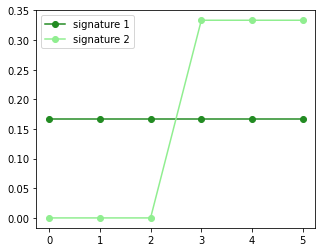

In [13]:
n = 50

signature1 = np.ones(6)/6
signature2 = np.array([0]*3 + [2]*3)/6

matplotlib.rcParams['figure.figsize'] = [5,4]
plt.plot(list(range(6)), signature1, '-o', color = 'forestgreen', label = "signature 1")
plt.plot(list(range(6)), signature2, '-o', color = 'lightgreen', label = "signature 2")
plt.legend()
plt.show()

total_n = 3*n
exposures = np.array([18,2]*n + [10,10]*n + [2,18]*n).reshape(total_n,2)
XMat1 = np.random.poisson(18*signature1 + 2*signature2, size = (n,6))
XMat2 = np.random.poisson(10*signature1 + 10*signature2, size = (n,6))
XMat3 = np.random.poisson(2*signature1 + 18*signature2, size = (n,6))
XMat = np.concatenate((XMat1, XMat2, XMat3))

In [14]:
print(18*signature1 + 2*signature2)
print(10*signature1 + 10*signature2)
print(2*signature1 + 18*signature2)
n_iter = 1000

[3.         3.         3.         3.66666667 3.66666667 3.66666667]
[1.66666667 1.66666667 1.66666667 5.         5.         5.        ]
[0.33333333 0.33333333 0.33333333 6.33333333 6.33333333 6.33333333]


## CVX NMF

We generate the siganture and exposure matrix using cvx nmf. In Ding et al. they consider a datamatrix with features as rows (same as Pei), which made sense with the Kmeans implementation. 
We implement it with observations as row, making is comparable to the estimation from the autoencoder. This also means that the Kmeans initialization does not make sense.
$$V = XGW  = FW$$

In [15]:
def est_cvx(X, rank):
    G_cvx, W_cvx = convex_nmf(X, rank, n_iter, init = "kmeans")
    signatures_cvx = X@W_cvx
    #exposures_cvx = X@W_cvx

    diagonals_cvx = signatures_cvx.sum(axis = 0)

    signatures_cvx = signatures_cvx@np.diag(1/diagonals_cvx)
    exposures_cvx = np.diag(diagonals_cvx)@G_cvx.T
    #exposures_cvx = exposures_cvx@np.diag(diagonals_cvx)
    #signatures_cvx = np.diag(1/diagonals_cvx)@(G_cvx.T)
    return(exposures_cvx, signatures_cvx)

## AE NMF

Signatures and exposures are extracted using the AE with ReLU + PG nn. and hyperparameters set after my gut feeling 

In [16]:
def est_AE(X, rank):
    model_AE = AAUtoSig(feature_dim = 6, latent_dim = rank, relu_activation = [True, False])

    optimizer = torch.optim.Adam(params=model_AE.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()

    X_pd = pd.DataFrame(X)
    _,_,_,signatures_AE, exposures_AE,_ = train_AAUtoSig(epochs = n_iter, model = model_AE, x_train = X_pd, x_test = X_pd, criterion = criterion, optimizer = optimizer, batch_size = 8, do_plot = True, non_negative = "bases")
    diagonals_AE = signatures_AE.sum(axis = 0)
    exposures_AE = (exposures_AE.T@np.diag(diagonals_AE)).to_numpy()
    signatures_AE = (np.diag(1/diagonals_AE)@(signatures_AE.T)).to_numpy()
    return(exposures_AE, signatures_AE)

## NMF

NMF with multiplicative updates

In [17]:
def est_nmf(X, rank):
    model_NMF = NMF(n_components=rank, solver='mu', beta_loss = 2, max_iter=n_iter, init="random")
    exposures_NMF = model_NMF.fit_transform(X)
    signatures_NMF = model_NMF.components_

    diagonals_NMF = signatures_NMF.sum(axis = 1)
    exposures_NMF = exposures_NMF@np.diag(diagonals_NMF)
    signatures_NMF = np.diag(1/diagonals_NMF)@signatures_NMF
    return(exposures_NMF, signatures_NMF)

## Plot results
We plot the true and estimated signatures and exposures for each method

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1
 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 0]


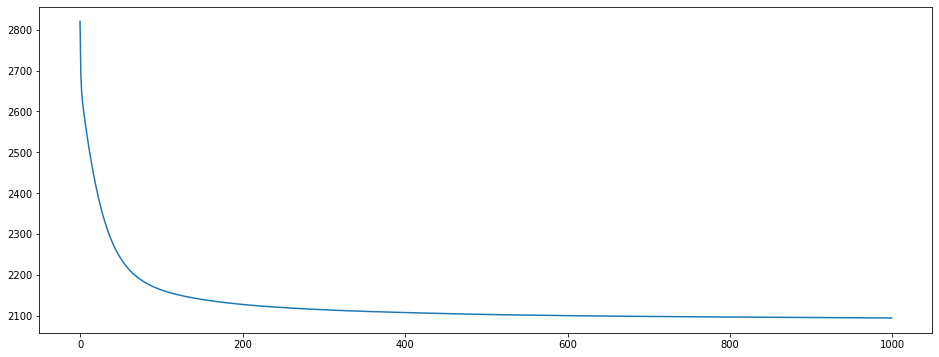

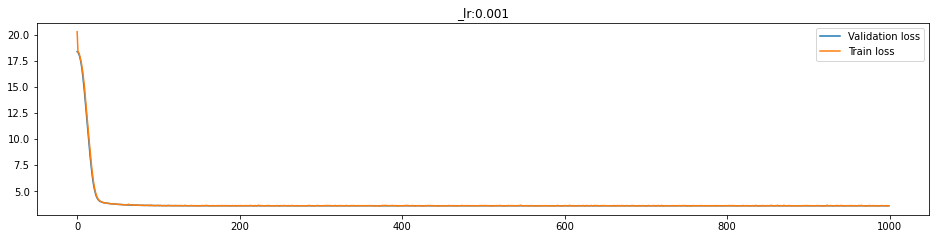

<Figure size 1152x432 with 0 Axes>

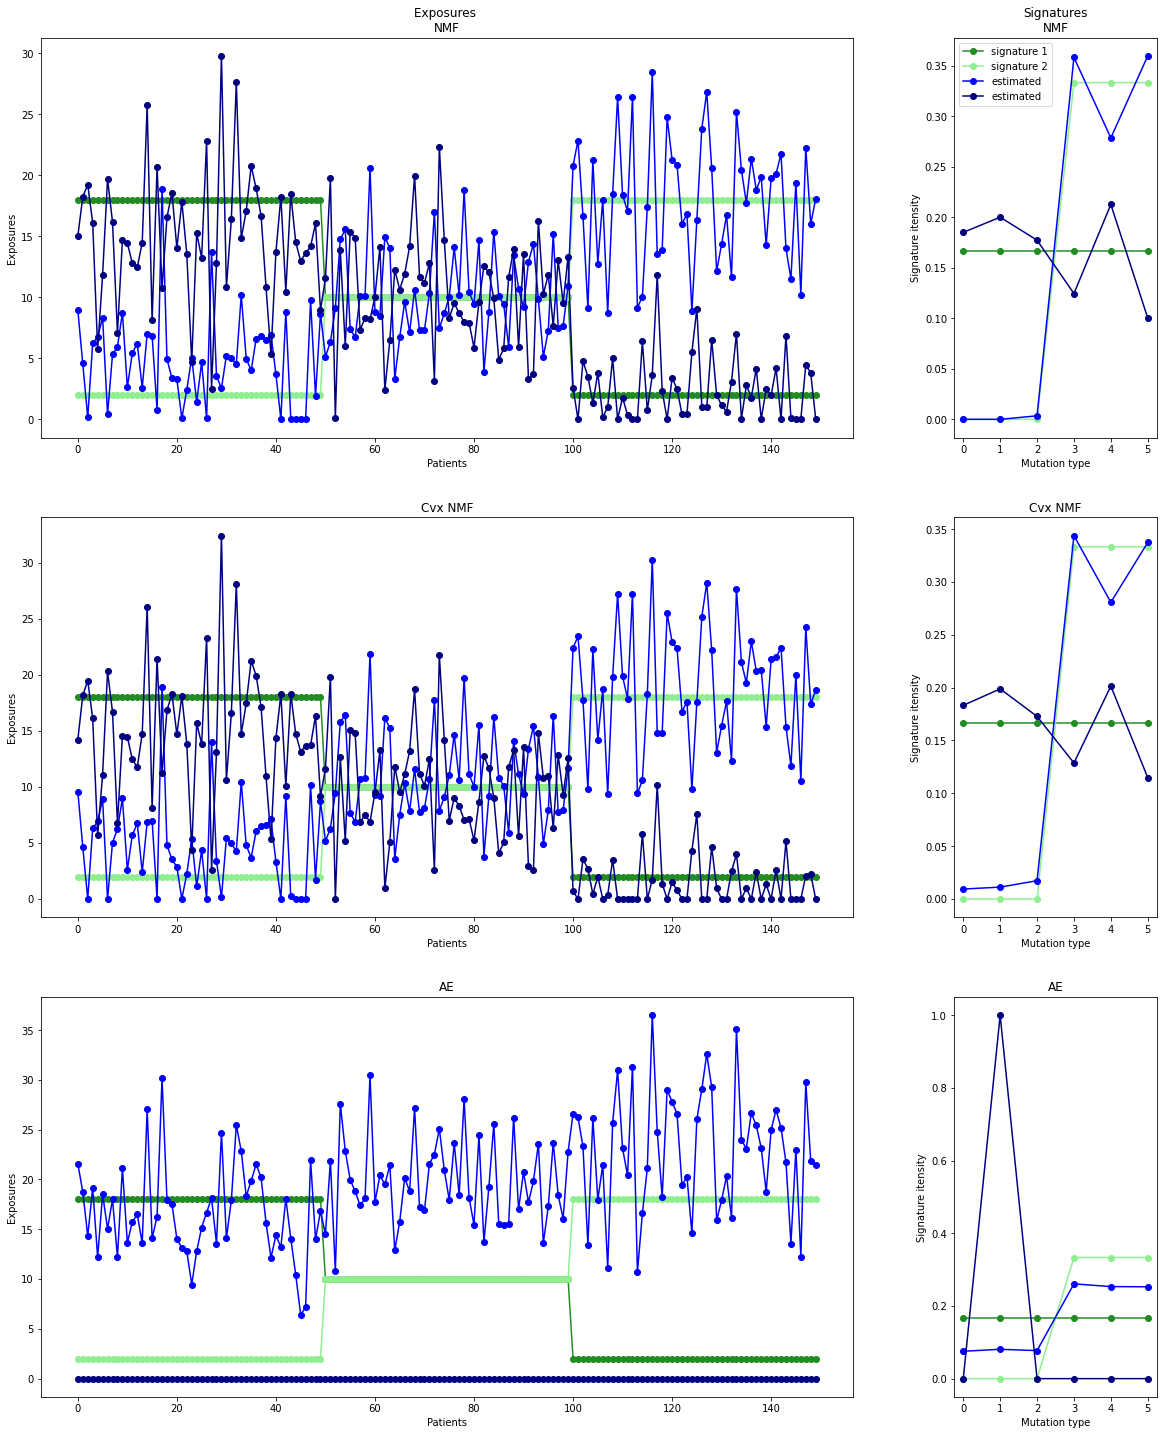

In [18]:
names = ["NMF", "Cvx NMF", "AE"]
matplotlib.rcParams['figure.figsize'] = [16, 6]

exposures_cvx, signatures_cvx = est_cvx(XMat.T, 2)
exposures_AE, signatures_AE = est_AE(XMat, 2)
exposures_NMF, signatures_NMF = est_nmf(XMat, 2) 

matplotlib.rcParams['figure.figsize'] = [20, 25]
fig1, axs1 = plt.subplots(3,2, width_ratios = [4,1])
for i, est in enumerate(((exposures_NMF, signatures_NMF), (exposures_cvx.T, signatures_cvx.T), (exposures_AE, signatures_AE))):
    exp, sig = est
    axs1[i,0].plot(list(range(total_n)), exposures[:,0], '-o', color = "forestgreen", label = "signature 1")
    axs1[i,0].plot(list(range(total_n)), exposures[:,1], '-o', color = "lightgreen", label = "signature 2")
    axs1[i,0].plot(list(range(total_n)), exp[:,0], '-o', color = "blue", label = "estimated")
    axs1[i,0].plot(list(range(total_n)), exp[:,1], '-o', color = "navy", label = "estimated")
    axs1[i,0].set_title(names[i])
    axs1[i,0].set_ylabel("Exposures")


    axs1[i,1].plot(list(range(6)), signature1, '-o', color = "forestgreen", label = "signature 1")
    axs1[i,1].plot(list(range(6)), signature2, '-o', color = "lightgreen", label = "signature 2")
    axs1[i,1].plot(list(range(6)), sig[0,:], '-o', color = "blue", label = "estimated")
    axs1[i,1].plot(list(range(6)), sig[1,:], '-o', color = "navy" , label = "estimated")
    if i != 0:
        axs1[i,1].set_title(names[i])
    axs1[i,1].set_ylabel("Signature itensity")

    axs1[0,0].set_title("Exposures \n" +  names[0])
    axs1[0,1].set_title("Signatures\n" + names[0])
    axs1[0,1].legend()

    axs1[i,0].set_xlabel("Patients")
    axs1[i,1].set_xlabel("Mutation type")


plt.show()

## More plots
This is a plot of the estimated Cvx NMF and AE signatures and exposures for different numbers of patients

[0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1]


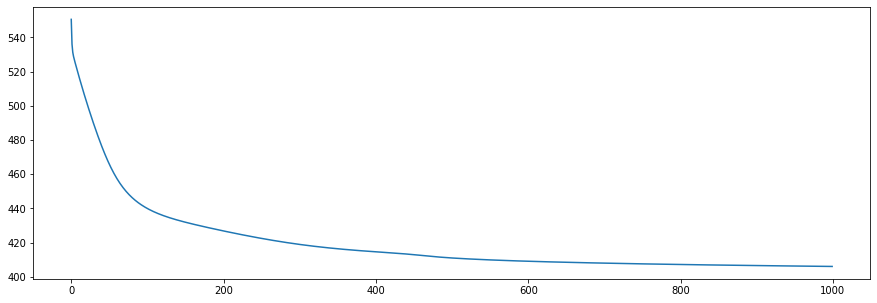

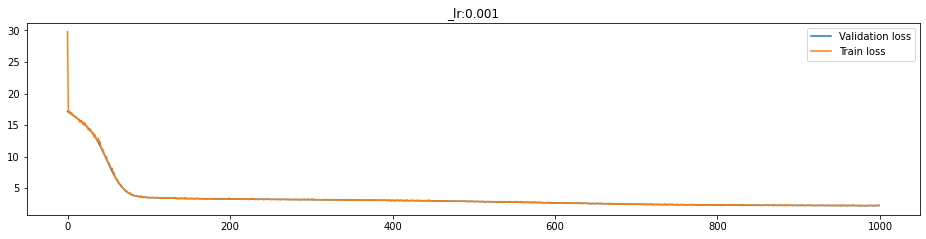

[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1
 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


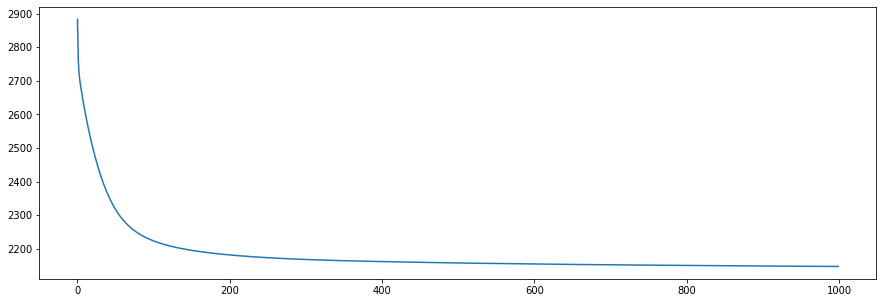

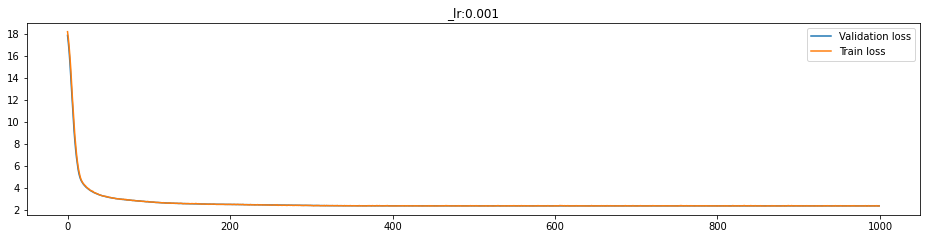

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1 0 1
 0 0 0 1 1 1 1 0 1 0 0 0 1 0 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 0 1 0 0 1 1 1 0
 1 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0
 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1]


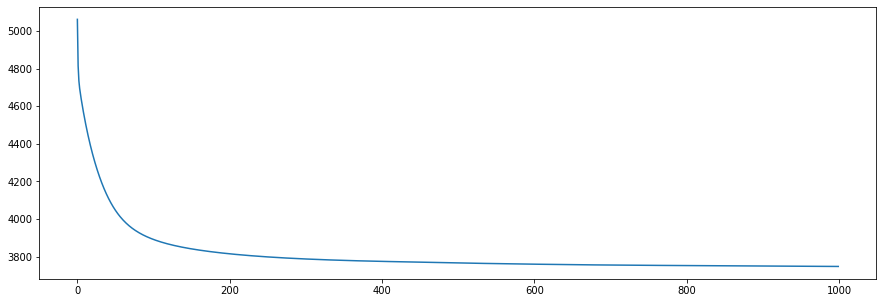

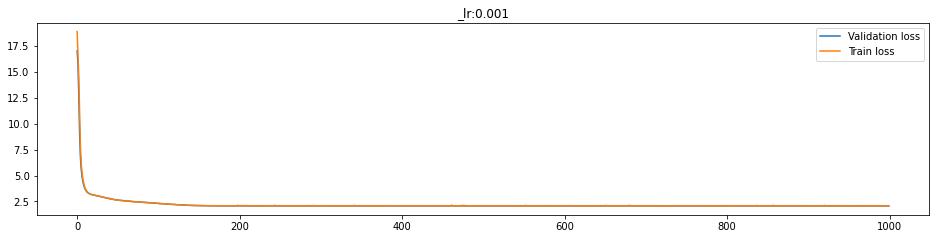

<Figure size 1080x360 with 0 Axes>

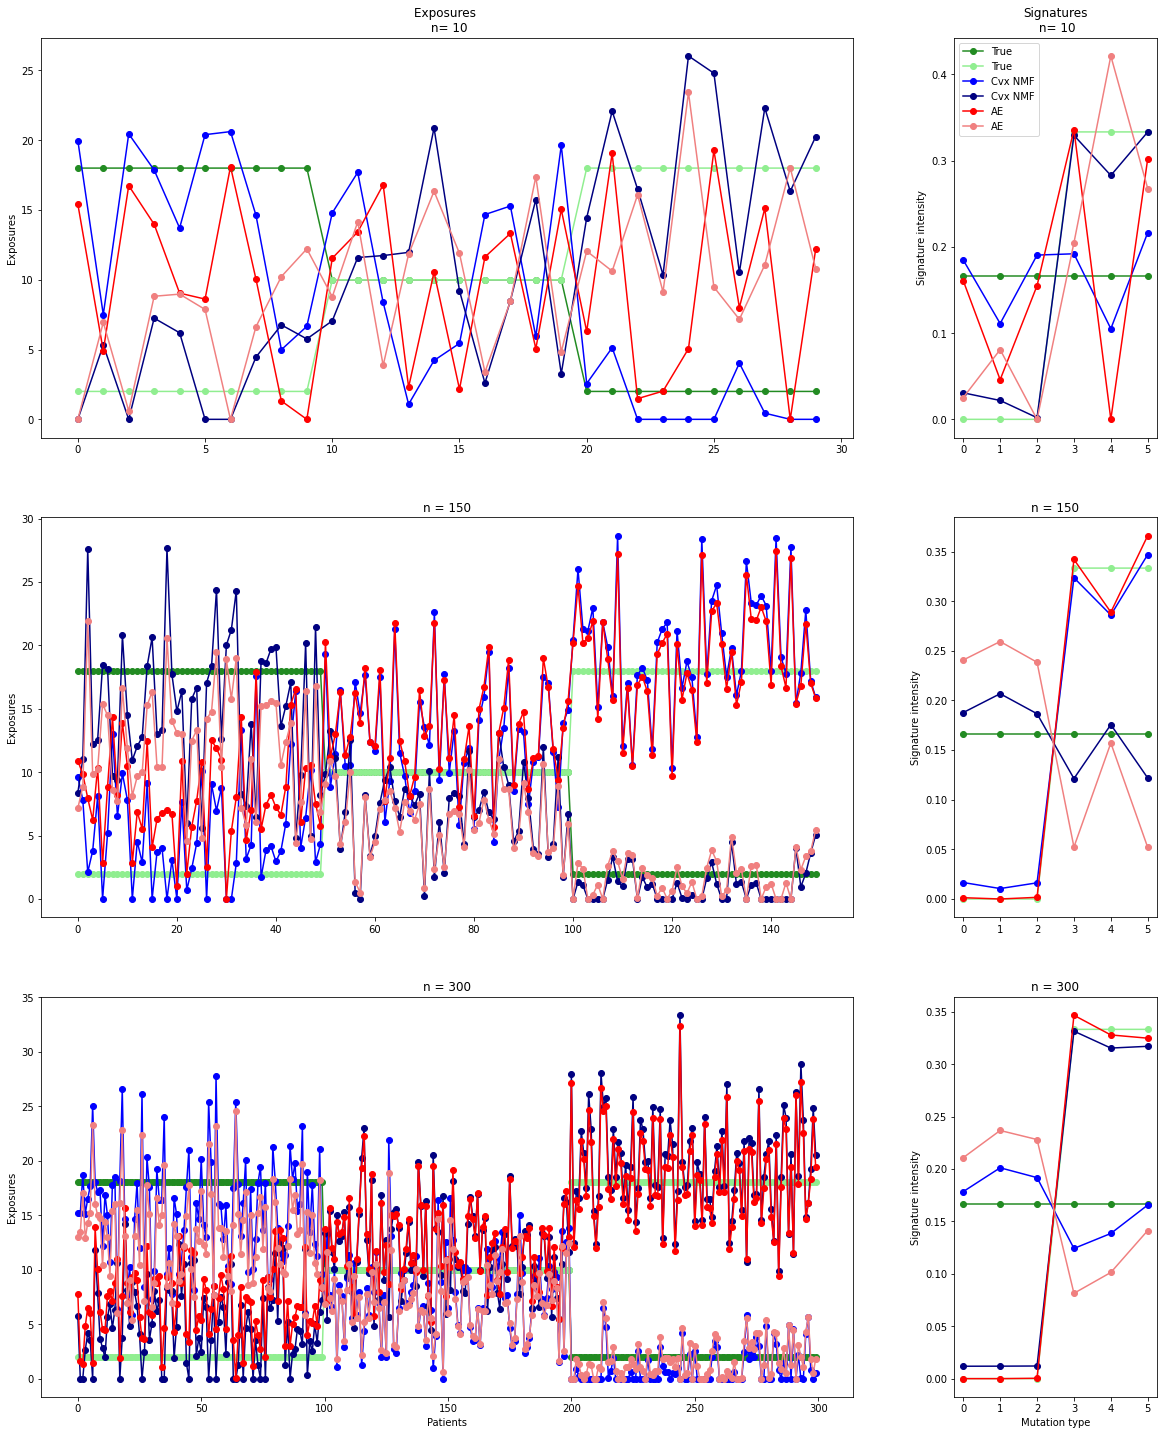

In [19]:
exposures_cvx_dict = dict()
exposures_AE_dict = dict()

exposures_cvx_dict = dict()
exposures_AE_dict = dict()

signatures_cvx_dict = dict()
signatures_AE_dict = dict()
matplotlib.rcParams['figure.figsize'] = [15, 5]
for n in [10, 50, 100]:
    total_n = 3*n
    XMat1 = np.random.poisson(18*signature1 + 2*signature2, size = (n,6))
    XMat2 = np.random.poisson(10*signature1 + 10*signature2, size = (n,6))
    XMat3 = np.random.poisson(2*signature1 + 18*signature2, size = (n,6))
    XMat = np.concatenate((XMat1, XMat2, XMat3))
    # ------------------------ Extraction ---------------------------------

    exposures_cvx, signatures_cvx = est_cvx(XMat.T, 2)
    exposures_AE, signatures_AE = est_AE(XMat, 2)
    
    exposures_cvx_dict[str(n)] = exposures_cvx.T
    exposures_AE_dict[str(n)] = exposures_AE
    
    signatures_cvx_dict[str(n)] = signatures_cvx.T
    signatures_AE_dict[str(n)] = signatures_AE

matplotlib.rcParams['figure.figsize'] = [20, 25]
fig2, axs2 = plt.subplots(3,2, width_ratios = [4,1])
for i,n in enumerate([10, 50, 100]):
    total_n = 3*n
    exposures = np.array([18,2]*n + [10,10]*n + [2,18]*n).reshape(total_n,2)
    # --------------------------- Plot results --------------------------------
    axs2[i,0].plot(list(range(total_n)), exposures[:,0], '-o', color = "forestgreen", label = "True")
    axs2[i,0].plot(list(range(total_n)), exposures[:,1], '-o', color = "lightgreen", label = "True")
    axs2[i,0].plot(list(range(total_n)), exposures_cvx_dict[str(n)][:,0], '-o', color = "blue", label = "Cvx NMF")
    axs2[i,0].plot(list(range(total_n)), exposures_cvx_dict[str(n)][:,1], '-o', color = "navy", label = "Cvx NMF")
    axs2[i,0].plot(list(range(total_n)), exposures_AE_dict[str(n)][:,0], '-o', color = "red", label = "AE")
    axs2[i,0].plot(list(range(total_n)), exposures_AE_dict[str(n)][:,1], '-o', color = "lightcoral", label = "AE")
    axs2[i,0].set_title('n = ' + str(total_n))
    axs2[i,0].set_ylabel("Exposures")

    axs2[i,1].plot(list(range(6)), signature1, '-o', color = "forestgreen", label = "True")
    axs2[i,1].plot(list(range(6)), signature2, '-o', color = "lightgreen", label = "True")
    axs2[i,1].plot(list(range(6)), signatures_cvx_dict[str(n)][0,:], '-o', color = "blue", label = "Cvx NMF")
    axs2[i,1].plot(list(range(6)), signatures_cvx_dict[str(n)][1,:], '-o', color = "navy" , label = "Cvx NMF")
    axs2[i,1].plot(list(range(6)), signatures_AE_dict[str(n)][0,:], '-o', color = "red", label = "AE")
    axs2[i,1].plot(list(range(6)), signatures_AE_dict[str(n)][1,:], '-o', color = "lightcoral",label = "AE")
    axs2[i,1].set_title('n = ' + str(total_n))
    axs2[i,1].set_ylabel("Signature intensity")

    if i == 0:
        axs2[0,0].set_title("Exposures \n n= " +  str(n))
        axs2[0,1].set_title("Signatures\n n= " +  str(n))
        axs2[0,1].legend()

    axs2[2,0].set_xlabel("Patients")
    axs2[2,1].set_xlabel("Mutation type")
plt.show()